## _Data Challenge | DeepWater_

#### Packages

In [3]:
!apt install tesseract-ocr
!apt-get install poppler-utils
!pip install pdf2image
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,720 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../tesserac

In [51]:
import nltk
import re
import sys
import numpy as np
from os import path
from scipy import sparse
import pandas as pd
import seaborn as sns
import xgboost as xgb
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy.linalg as linalg
import scipy
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import pdist, cdist, squareform
import pickle
from pdf2image import convert_from_path
import os
import pytesseract
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
try:
    from PIL import Image
except ImportError:
    import Image
import re

from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Chargement des données et Aperçu

In [6]:
df = pd.read_csv('dataset_tesseract.csv', sep = ';')
df.head()

,Text,nbcaracteres,label
0,FORMATION PRESSURE WORKSHEET Well No. : 6305/1...,450,1
1,SANTOS LIMITED RCI PRESSURE SURVEY WELL: BALCA...,2330,1
2,-GGryoro RFT RESULTS WELL: 6407/7-—2 RUN NO. 2...,1473,1
3,SANTOS LIMITED FMT PRESSURE SURVEY (Field Data...,2943,1
4,1 Test No. 10 2 MD mRKB 2006.0 2006.2 3 TVD m...,2158,1


#### Informations sur les données

In [7]:
df.info()
print('----------------------------------')
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          150 non-null    object
 1   nbcaracteres  150 non-null    int64 
 2   label         150 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ KB
----------------------------------
(150, 3)


Nous rétirons 10 documensts du dataset pour un test final de performance

In [8]:
for_test = pd.concat([df.iloc[:5,:], df.iloc[-5:,:]]).reset_index().drop(columns=["index"])
dataset = df.iloc[5:-5, :].reset_index().drop(columns=["index"])

### Prétraitement du texte | Text cleanning

In [9]:
stop_words = set(stopwords.words("english"))

In [10]:
corpus = []
for i in range(0, dataset.shape[0]):
    # Suppression des ponctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Text'][i])
    
    # convertir en minuscule
    text = text.lower()
    
    # Suppression des balises
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # suppression des caracères spéciaux
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Conversion en liste
    text = text.split()
    
    # normalisation de type lammélisation (on extrait de chaque mot les expressions non régulières)
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [11]:
corpus[11]

'b schlumberger rft tool table depth hydrostatic formation comment final form rkb psi psi seal tight tight increas tight retract tight increas seal failure tight press seal failure seal failure tight press good perm good perm good perm good perm low fair perm tight seal failure tight press seal failure tight tight increas o tight increas'

### Text Preparation

- La tokenisation est le processus de conversion du texte continu en une liste de mots.



- La vectorisation, appelée extraction de caractéristiques convertie la liste de mots en une matrice d'entiers par le processus de vectorisation.


#### Important


Je ne considère pas les séquences de mots, mais plutot la fréquence des mots.

##### Paramètres de la fonction

- max_df : Lors de la construction du vocabulaire, ignorez les termes qui ont une fréquence strictement supérieure au seuil donné dans le corpus. Cela permet de s'assurer que nous n'avons que des mots pertinents pour le contexte et non des mots couramment utilisés.




- max_features: détermine le nombre de colonnes dans la matrice.



- n-gram_range : nous voudrions regarder une liste de mots simples, deux mots (bi-grammes) et trois mots (tri-grammes) combinaisons.

In [65]:
len(corpus)

140

In [63]:
cv = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 60, ngram_range = (1,3))
X = cv.fit_transform(corpus)

(140, 60)

In [15]:
with open("CountVectorizer", "wb") as f:
    pickle.dump(cv, f)

In [16]:
print(list(cv.vocabulary_.keys()))

['date', 'run', 'hole', 'rkb', 'valid', 'good', 'permeability', 'seal', 'tight', 'well', 'rft', 'result', 'fm', 'pressure', 'gauge', 'psia', 'sample', 'test', 'type', 'page', 'formation', 'depth', 'md', 'drawdown', 'time', 'min', 'psi', 'gr', 'correlation', 'patchawarra', 'normal', 'rapid', 'slow', 'curtailed', 'psia psia', 'water', 'gradient', 'table', 'mud', 'ee', 'sand', 'ft', 'mrkb', 'perm', 'stepper', 'repeat', 'lost', 'summary', 'good test', 'hr', 'log', 'virgin', 'point', 'virgin good', 'virgin good test', 'interval', 'logging', 'core', 'cnl', 'group']


### Visualisation des tops occurence de mots (uni, bi et tri)

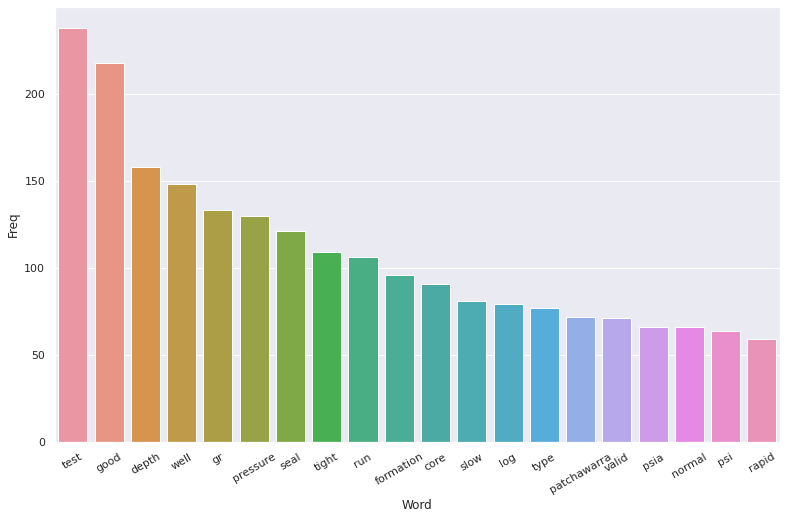

In [17]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
# print(top_df)
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

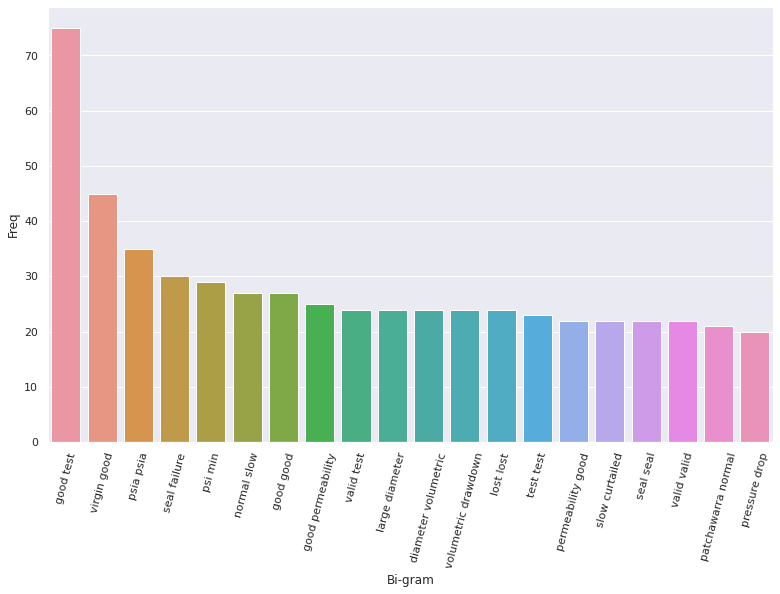

In [18]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
# print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=75);

In [19]:
# Conversion de la matrice en entier
# tfidf_transformer = TfidfTransformer(smooth_idf = True,use_idf = True)
# tfidf_transformer.fit(X)
# get feature names
# feature_names = cv.get_feature_names_out()
# feature_names

In [20]:
X1 = sparse.csr_matrix.toarray(X)

In [21]:
X1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 4, ..., 0, 0, 2],
       ...,
       [0, 3, 0, ..., 0, 6, 3],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
input_val = pd.DataFrame(X1)

In [23]:
Y = dataset.iloc[:,2]

In [24]:
Y

0      1
1      1
2      1
3      1
4      1
      ..
135    0
136    0
137    0
138    0
139    0
Name: label, Length: 140, dtype: int64

### Oversampling des données

In [25]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(input_val, Y)

In [26]:
X_over.shape

(190, 60)

In [27]:
y_over.shape

(190,)

In [28]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_over, y_over,test_size = 0.20)
print(X_train1.shape,X_test1.shape,Y_train1.shape,Y_test1.shape)

(152, 60) (38, 60) (152,) (38,)


## Modèle hybride combinant Reservoir et modèle de ML

In [75]:
class Reservoir(object):
    """
    Build a reservoir and evaluate internal states
    
    Parameters:
        n_internal_units = processing units in the reservoir
        spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
        leak = amount of leakage in the reservoir state update (optional)
        connectivity = percentage of nonzero connection weights (unused in circle reservoir)
        input_scaling = scaling of the input connection weights
        noise_level = deviation of the Gaussian noise injected in the state update
        circle = generate determinisitc reservoir with circle topology
    """
    
    def __init__(self, n_internal_units=100, spectral_radius=0.99, leak=None,
                 connectivity=0.3, input_scaling=0.2, noise_level=0.01, circle=False):
        
        # Initialize attributes
        self._n_internal_units = n_internal_units
        self._input_scaling = input_scaling
        self._noise_level = noise_level
        self._leak = leak

        # Input weights depend on input size: they are set when data is provided
        self._input_weights = None

        # Generate internal weights
        if circle:
            self._internal_weights = self._initialize_internal_weights_Circ(
                    n_internal_units,
                    spectral_radius)
        else:
            self._internal_weights = self._initialize_internal_weights(
                n_internal_units,
                connectivity,
                spectral_radius)


    def _initialize_internal_weights_Circ(self, n_internal_units, spectral_radius):
        
        # Construct reservoir with circular topology
        internal_weights = np.zeros((n_internal_units, n_internal_units))
        internal_weights[0,-1] = 1.0
        for i in range(n_internal_units-1):
            internal_weights[i+1,i] = 1.0
            
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius 
                
        return internal_weights
    
    
    def _initialize_internal_weights(self, n_internal_units,
                                     connectivity, spectral_radius):

        # Generate sparse, uniformly distributed weights.
        internal_weights = sparse.rand(n_internal_units,
                                       n_internal_units,
                                       density=connectivity).todense()

        # Ensure that the nonzero values are uniformly distributed in [-0.5, 0.5]
        internal_weights[np.where(internal_weights > 0)] -= 0.5
        
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius       

        return internal_weights


    def _compute_state_matrix(self, X, n_drop=0):
        N, T, _ = X.shape
        previous_state = np.zeros((N, self._n_internal_units), dtype=float)

        # Storage
        state_matrix = np.empty((N, T - n_drop, self._n_internal_units), dtype=float)

        for t in range(T):
            current_input = X[:, t, :]

            # Calculate state
            state_before_tanh = self._internal_weights.dot(previous_state.T) + self._input_weights.dot(current_input.T)

            # Add noise
            state_before_tanh += np.random.rand(self._n_internal_units, N)*self._noise_level

            # Apply nonlinearity and leakage (optional)
            if self._leak is None:
                previous_state = np.tanh(state_before_tanh).T
            else:
                previous_state = (1.0 - self._leak)*previous_state + np.tanh(state_before_tanh).T

            # Store everything after the dropout period
            if (t > n_drop - 1):
                state_matrix[:, t - n_drop, :] = previous_state

        return state_matrix


    def get_states(self, X, n_drop=0, bidir=True):
        N, T, V = X.shape
        if self._input_weights is None:
            self._input_weights = (2.0*np.random.binomial(1, 0.5 , [self._n_internal_units, V]) - 1.0)*self._input_scaling

        # compute sequence of reservoir states
        states = self._compute_state_matrix(X, n_drop)
    
        # reservoir states on time reversed input
        if bidir is True:
            X_r = X[:, ::-1, :]
            states_r = self._compute_state_matrix(X_r, n_drop)
            states = np.concatenate((states, states_r), axis=2)

        return states


In [76]:
class tensorPCA:
    
    def __init__(self, n_components):
        self.n_components=n_components
        self.first_eigs = None
        
    def fit(self, X): # X has shape [N,T,V]
        
        if len(X.shape) is not 3:
            raise RuntimeError('Input must be a 3d tensor')
        
        Xt = np.swapaxes(X,1,2)  # [N,T,V] --> [N,V,T]
        Xm = np.expand_dims(np.mean(X, axis=0), axis=0) # mean sample
        Xmt = np.swapaxes(Xm,1,2)
        
        C = np.tensordot(X-Xm,Xt-Xmt,axes=([1,0],[2,0])) / (X.shape[0]-1) # covariance of 0-mode slices
        
        # sort eigenvalues of covariance matrix
        eigenValues, eigenVectors = linalg.eig(C)
        idx = eigenValues.argsort()[::-1]   
        eigenVectors = eigenVectors[:,idx]
        
        self.first_eigs = eigenVectors[:,:self.n_components]
        
        
    def transform(self, X):
        return np.einsum('klj,ji->kli',X,self.first_eigs)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [88]:
def compute_test_scores(pred_class, Yte):
    """
    Wrapper to compute classification accuracy and F1 score
    """
    
    true_class = np.argmax(Yte, axis=1)
    
    accuracy = accuracy_score(true_class, pred_class)
    if Yte.shape[1] > 2:
        f1 = f1_score(true_class, pred_class, average='weighted')
    else:
        f1 = f1_score(true_class, pred_class, average='binary')

    return accuracy, f1

            
class RC_model(object):
    
    def __init__(self,
              # reservoir
              reservoir=None,     
              n_internal_units=None,
              spectral_radius=None,
              leak=None,
              connectivity=None,
              input_scaling=None,
              noise_level=None,
              n_drop=None,
              bidir=False,
              circle=False,
              # dim red
              dimred_method=None, 
              n_dim=None,
              # representation
              mts_rep=None,
              w_ridge_embedding=None,
              # readout
              readout_type=None,               
              w_ridge=None,              
              mlp_layout=None,
              num_epochs=None,
              w_l2=None,
              nonlinearity=None, 
              svm_gamma=1.0,
              svm_C=1.0,
              rdf_n_estimators=100,
              rdf_criterion='gini',
              rdf_max_depth=None
              ):
        """
        Build and evaluate a RC-based classifier.
        The training and test MTS are multidimensional arrays of shape [N,T,V], with
            - N = number of samples
            - T = number of time steps in each sample
            - V = number of variables in each sample
        Training and test labels have shape [N,C], with C the number of classes
        
        The dataset consists of:
            X, Y = training data and respective labels
            Xte, Yte = test data and respective labels
            
        Reservoir parameters:
            reservoir = precomputed reservoir (oject of class 'Reservoir');
                if None, the following structural hyperparameters must be specified
            n_internal_units = processing units in the reservoir
            spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
            leak = amount of leakage in the reservoir state update (optional)
            connectivity = percentage of nonzero connection weights
            input_scaling = scaling of the input connection weights
            noise_level = deviation of the Gaussian noise injected in the state update
            n_drop = number of transient states to drop
            bidir = use a bidirectional reservoir (True or false)
                
        Dimensionality reduction parameters:
            dimred_method = procedure for reducing the number of features in the sequence of reservoir states;
                possible options are: None (no dimensionality reduction), 'pca' or 'tenpca'
            n_dim = number of resulting dimensions after the dimensionality reduction procedure
            
        Representation parameters:
            mts_rep = type of MTS representation. It can be 'last' (last state), 'output' (output model space),
                or 'reservoir' (reservoir model space)
            w_ridge_embedding = regularization parameter of the ridge regression in the output model space
                and reservoir model space representation; ignored if mts_rep == None
            
        Readout parameters:
            readout_type = type of readout used for classification. It can be 'lin' (ridge regression), 
                'mlp' (multiplayer perceptron), 'svm' (support vector machine), or None.
                If None, the input representations will be saved instead: this is useful for clustering and visualization.
            w_ridge = regularization parameter of the ridge regression readout (only for readout_type=='lin')              
            mlp_layout = tuple with the sizes of MLP layers, e.g. (20, 10) defines a MLP with 2 layers 
                of 20 and 10 units respectively. (only for readout_type=='mlp')
            num_epochs = number of iterations during the optimization (only for readout_type=='mlp')
            w_l2 = weight of the L2 regularization (only for readout_type=='mlp')
            nonlinearity = type of activation function {'relu', 'tanh', 'logistic', 'identity'} (only for readout_type=='mlp')
            svm_gamma = bandwith of the RBF kernel (only for readout_type=='svm')
            svm_C = regularization for SVM hyperplane (only for readout_type=='svm')
            rdf_n_estimators = The number of trees in the forest (only for readout_type=='rdf')
            rdf_criterion = The function to measure the quality of a split (only for readout_type=='rdf')
            rdf_max_depth = The maximum depth of the tree (only for readout_type=='rdf')
        """
        self.n_drop=n_drop
        self.bidir=bidir
        self.dimred_method=dimred_method
        self.mts_rep=mts_rep
        self.readout_type=readout_type
        self.svm_gamma=svm_gamma
                        
        # Initialize reservoir
        if reservoir is None:
            self._reservoir = Reservoir(n_internal_units=n_internal_units,
                                  spectral_radius=spectral_radius,
                                  leak=leak,
                                  connectivity=connectivity,
                                  input_scaling=input_scaling,
                                  noise_level=noise_level,
                                  circle=circle)
        else:
            self._reservoir = reservoir
                
        # Initialize dimensionality reduction method
        if dimred_method is not None:
            if dimred_method.lower() == 'pca':
                self._dim_red = PCA(n_components=n_dim)            
            elif dimred_method.lower() == 'tenpca':
                self._dim_red = tensorPCA(n_components=n_dim)
            else:
                raise RuntimeError('Invalid dimred method ID')
                
        # Initialize ridge regression model
        if mts_rep=='output' or mts_rep=='reservoir':
            self._ridge_embedding = Ridge(alpha=w_ridge_embedding, fit_intercept=True)
                        
        # Initialize readout type            
        if self.readout_type is not None:
            
            if self.readout_type == 'lin': # Ridge regression
                self.readout = Ridge(alpha=w_ridge)        
            elif self.readout_type == 'svm': # SVM readout
                self.readout = SVC(C=svm_C, kernel='precomputed')
            elif self.readout_type == 'rdf': # RandomForest readout
                self.readout = RandomForestClassifier(rdf_n_estimators, criterion=rdf_criterion, max_depth=rdf_max_depth)          
            elif readout_type == 'mlp': # MLP (deep readout)  
                # pass
                self.readout = MLPClassifier(
                    hidden_layer_sizes=mlp_layout, 
                    activation=nonlinearity, 
                    alpha=w_l2,
                    batch_size=32, 
                    learning_rate='adaptive', # 'constant' or 'adaptive'
                    learning_rate_init=0.001, 
                    max_iter=num_epochs, 
                    early_stopping=False, # if True, set validation_fraction > 0
                    validation_fraction=0.0 # used for early stopping
                    )
            else:
                raise RuntimeError('Invalid readout type')  
        
        
    def train(self, X, Y=None):
        
        time_start = time.time()
        
        # ============ Compute reservoir states ============ 
        res_states = self._reservoir.get_states(X, n_drop=self.n_drop, bidir=self.bidir)
        
        # ============ Dimensionality reduction of the reservoir states ============  
        if self.dimred_method.lower() == 'pca':
            # matricize
            N_samples = res_states.shape[0]
            res_states = res_states.reshape(-1, res_states.shape[2])                   
            # ..transform..
            red_states = self._dim_red.fit_transform(res_states)          
            # ..and put back in tensor form
            red_states = red_states.reshape(N_samples,-1,red_states.shape[1])          
        elif self.dimred_method.lower() == 'tenpca':
            red_states = self._dim_red.fit_transform(res_states)       
        else: # Skip dimensionality reduction
            red_states = res_states

        # ============ Generate representation of the MTS ============
        coeff_tr = []
        biases_tr = []   
        
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                X = np.concatenate((X,X[:, ::-1, :]),axis=2)                
                
            for i in range(X.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], X[i, self.n_drop+1:, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
            
        # Reservoir model space representation
        elif self.mts_rep=='reservoir':
            for i in range(X.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        
        # Last state representation        
        elif self.mts_rep=='last':
            input_repr = red_states[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr = np.mean(red_states, axis=1)
            
        else:
            raise RuntimeError('Invalid representation ID')            
            
        # ============ Apply readout ============
        if self.readout_type == None: # Just store the input representations
            self.input_repr = input_repr
            
        elif self.readout_type == 'lin': # Ridge regression
            self.readout.fit(input_repr, Y)          
            
        elif self.readout_type == 'svm': # SVM readout
            Ktr = squareform(pdist(input_repr, metric='sqeuclidean')) 
            Ktr = np.exp(-self.svm_gamma*Ktr)
            self.readout.fit(Ktr, np.argmax(Y,axis=1))
            self.input_repr_tr = input_repr # store them to build test kernel
        
        elif self.readout_type == 'rdf': # Random Forest
            self.readout.fit(input_repr, np.argmax(Y,axis=1))

        elif self.readout_type == 'mlp': # MLP (deep readout)
            self.readout.fit(input_repr, Y)
                        
        tot_time = (time.time()-time_start)/60
        return tot_time

            
    def test(self, Xte, Yte):

        # ============ Compute reservoir states ============
        res_states_te = self._reservoir.get_states(Xte, n_drop=self.n_drop, bidir=self.bidir) 
        
        # ============ Dimensionality reduction of the reservoir states ============ 
        if self.dimred_method.lower() == 'pca':
            # matricize
            N_samples_te = res_states_te.shape[0]
            res_states_te = res_states_te.reshape(-1, res_states_te.shape[2])                    
            # ..transform..
            red_states_te = self._dim_red.transform(res_states_te)            
            # ..and put back in tensor form
            red_states_te = red_states_te.reshape(N_samples_te,-1,red_states_te.shape[1])            
        elif self.dimred_method.lower() == 'tenpca':
            red_states_te = self._dim_red.transform(res_states_te)        
        else: # Skip dimensionality reduction
            red_states_te = res_states_te             
        
        # ============ Generate representation of the MTS ============
        coeff_te = []
        biases_te = []   
        
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                Xte = np.concatenate((Xte,Xte[:, ::-1, :]),axis=2)  
                    
            for i in range(Xte.shape[0]):
                self._ridge_embedding.fit(red_states_te[i, 0:-1, :], Xte[i, self.n_drop+1:, :])
                coeff_te.append(self._ridge_embedding.coef_.ravel())
                biases_te.append(self._ridge_embedding.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)
        
        # Reservoir model space representation
        elif self.mts_rep=='reservoir':    
            for i in range(Xte.shape[0]):
                self._ridge_embedding.fit(red_states_te[i, 0:-1, :], red_states_te[i, 1:, :])
                coeff_te.append(self._ridge_embedding.coef_.ravel())
                biases_te.append(self._ridge_embedding.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)
    
        # Last state representation        
        elif self.mts_rep=='last':
            input_repr_te = red_states_te[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr_te = np.mean(red_states_te, axis=1)
            
        else:
            raise RuntimeError('Invalid representation ID')   
            
        # ============ Apply readout ============
        if self.readout_type == 'lin': # Ridge regression        
            logits = self.readout.predict(input_repr_te)
            pred_class = np.argmax(logits, axis=1)
            
        elif self.readout_type == 'svm': # SVM readout
            Kte = cdist(input_repr_te, self.input_repr_tr, metric='sqeuclidean')
            Kte = np.exp(-self.svm_gamma*Kte)
            pred_class = self.readout.predict(Kte)
        
        elif self.readout_type == 'rdf': # Random Forest readout
            pred_class = self.readout.predict(input_repr_te)

        elif self.readout_type == 'mlp': # MLP (deep readout)
            pred_class = self.readout.predict(input_repr_te)
            pred_class = np.argmax(pred_class, axis=1)
            
        if Yte is not None:
            accuracy, f1 = compute_test_scores(pred_class, Yte)
            return accuracy, f1
        else:
            return pred_class

    def predict(self, X):
        return self.test(X, None)


In [78]:
# ============ RC model configuration and hyperparameter values ============

config = {}

config["seed"] = 32

np.random.seed(config["seed"])

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.59        # largest eigenvalue of the reservoir
config['leak'] = 0.6                    # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circ'] = False                  # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] ='tenpca'       # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation:  {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Linear readout hyperparameters
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

# SVM readout hyperparameters
config['svm_gamma'] = 0.005             # bandwith of the RBF kernel
config['svm_C'] = 5.0                   # regularization for SVM hyperplane

# MLP readout hyperparameters
config['mlp_layout'] = (10,10)          # neurons in each MLP layer
config['num_epochs'] = 2000             # number of epochs 
config['w_l2'] = 0.001                  # weight of the L2 regularization
config['nonlinearity'] = 'relu'         # type of activation function {'relu', 'tanh', 'logistic', 'identity'}

# Random Forest readout hyperparameters
config['rdf_n_estimators'] = 100            # number of trees
config['rdf_criterion'] = "gini"            # function to measure the quality of a split 
config['rdf_max_depth'] = None              # max deepth of the trees

print(config)

# ============ Load dataset ============
X_over_np, y_over_np = X_over.to_numpy(), y_over.to_numpy()
X_over_np = np.reshape(X_over_np, (X_over_np.shape[0], X_over_np.shape[1], 1))
X_train, X_test, Y_train, Y_test = train_test_split(X_over_np, y_over_np,test_size = 0.20)


# # One-hot encoding for labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test = onehot_encoder.transform(Y_test.reshape(-1, 1))


{'seed': 32, 'n_internal_units': 450, 'spectral_radius': 0.59, 'leak': 0.6, 'connectivity': 0.25, 'input_scaling': 0.1, 'noise_level': 0.01, 'n_drop': 5, 'bidir': True, 'circ': False, 'dimred_method': 'tenpca', 'n_dim': 75, 'mts_rep': 'reservoir', 'w_ridge_embedding': 10.0, 'w_ridge': 5.0, 'svm_gamma': 0.005, 'svm_C': 5.0, 'mlp_layout': (10, 10), 'num_epochs': 2000, 'w_l2': 0.001, 'nonlinearity': 'relu', 'rdf_n_estimators': 100, 'rdf_criterion': 'gini', 'rdf_max_depth': None}


### Evaluation avec Ridge

In [79]:
# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}


# ============ Initialize, train and evaluate the RC model ============
classifier_lin =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C'],
                        rdf_n_estimators=config["rdf_n_estimators"],
                        rdf_criterion=config["rdf_criterion"],
                        rdf_max_depth=config["rdf_max_depth"]
                        )

tr_time = classifier_lin.train(X_train, Y_train)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier_lin.test(X_test, Y_test)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))


Training time = 0.09 seconds
Accuracy = 0.842, F1 = 0.875


### Evaluation avec SVM

In [80]:
# Type of readout
config['readout_type'] = 'svm'          # readout used for classification: {'lin', 'mlp', 'svm'}


# ============ Initialize, train and evaluate the RC model ============
classifier_svm =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C'],
                        rdf_n_estimators=config["rdf_n_estimators"],
                        rdf_criterion=config["rdf_criterion"],
                        rdf_max_depth=config["rdf_max_depth"]
                        )

tr_time = classifier_svm.train(X_train, Y_train)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier_svm.test(X_test, Y_test)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))


Training time = 0.09 seconds
Accuracy = 0.658, F1 = 0.683


### Evaluation avec MLP

In [89]:
# Type of readout
config['readout_type'] = 'mlp'          # readout used for classification: {'lin', 'mlp', 'svm'}


# ============ Initialize, train and evaluate the RC model ============
classifier_mlp =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C'],
                        rdf_n_estimators=config["rdf_n_estimators"],
                        rdf_criterion=config["rdf_criterion"],
                        rdf_max_depth=config["rdf_max_depth"]
                        )

tr_time = classifier_mlp.train(X_train, Y_train)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier_mlp.test(X_test, Y_test)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))


Training time = 0.23 seconds
Accuracy = 0.895, F1 = 0.926


### Evaluation avec Random Forest

In [82]:
# Type of readout
config['readout_type'] = 'rdf'          # readout used for classification: {'lin', 'mlp', 'svm'}


# ============ Initialize, train and evaluate the RC model ============
classifier_rdf =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C'],
                        rdf_n_estimators=config["rdf_n_estimators"],
                        rdf_criterion=config["rdf_criterion"],
                        rdf_max_depth=config["rdf_max_depth"]
                        )

tr_time = classifier_rdf.train(X_train, Y_train)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier_rdf.test(X_test, Y_test)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))


Training time = 0.10 seconds
Accuracy = 0.921, F1 = 0.945


Le meilleur modèle est le modèle couplant Réservoir et réseau de neurones

In [90]:
with open("classifier_mlp", "wb") as f:
    pickle.dump(classifier_mlp, f)

# Pipeline de traitrement

In [84]:
def text_to_model(file_path):
    """ Extraction des données des fiucher pdf"""

    image = convert_from_path(file_path)
    text = pytesseract.image_to_string(image[0])
    text = re.sub(r";+", " ", text)
    text = re.sub(r"\s+", " ", text)
    

    #   Récupération de ma liste des stop words
    stop_words = set(stopwords.words("english"))

    # Suppression des ponctuations
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # convertir en minuscule
    text = text.lower()
    
    # Suppression des balises
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # suppression des caracères spéciaux
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Conversion en liste
    text = text.split()
    
    # lémmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)

    #   Conversion du texte en vecteurs
    #   Récupérer CV depuis un fichier
    
    cv = pickle.load( open("CountVectorizer", "rb" ) )
    X = cv.transform([text])

    #   Conversion de la matrice en entier
    X = sparse.csr_matrix.toarray(X)
    X = X.reshape((1, X.shape[1], 1))
    return X



matrice = text_to_model("./zoi_6.pdf")


In [91]:
model = pickle.load(open("classifier_mlp", "rb" ))

print(model.predict(matrice))

[1]
